# **BUSI 488 / COMP 488 Data Science in the Business World**
## *Spring 2023*  
Daniel M. Ringel  
Kenan-Flagler Business School  
*The University of North Carolina at Chapel Hill*  
dmr@unc.edu

## Class 17 - Predictive Modelling III


![Predictive Modelling](https://www.sqlservercentral.com/wp-content/uploads/legacy/633ea83070547be9a51f5c76a3a03e8b1e3d0546/predictivemodeling-steps1.jpg)

*March 9, 2023*  
Version 1.0


# Today's Agenda

1. **Empirical Setting**
2. **Training Set Size with Learning Curves**
3. **Dealing with Class Imbalance**
4. **Feature Importance in Tree Models**

## Prep-Check:
- Reviewed Python Notebook from Class 16
- **Read before class:**  Neslin, S.A., Gupta, S., Kamakura, W., Lu, J. and Mason, C.H., 2006. Defection detection: [Measuring and understanding the predictive accuracy of customer churn models](https://kenan-flagler.instructure.com/files/250306187/download?download_frd=1) . Journal of Marketing Research, 43(2), pp. 204-211.   


# 1 Empirical Setting: ***Customer Eligibility for a Loan***

[*Based on an Analytics Vidhya practice competition*](https://datahack.analyticsvidhya.com/contest/practice-problem-loan-prediction-iii/)

A Fintech wants to automate the loan eligibility process (in real time) based on the details that applicants provide in their online application. These details are:

- Gender
- Marital Status
- Education
- Number of Dependents
- Income
- Loan Amount
- Credit History and others. 

To automate this process, the Fintech needs to assign applicants to either being eligible for the requested loan (amount), or not. You are provided with a training dataset in which the loan eligibility is marked. 
The dataset contains the following variables:

| Variable          	| Description                     	|
|-------------------	|---------------------------------	|
| Loan_ID           	| Unique Loan ID                  	|
| Gender            	| Male/ Female                    	|
| Married           	| Applicant married (Y/N)         	|
| Dependents        	| Number of dependents            	|
| Education         	| Graduate/ Under Graduate        	|
| Self_Employed     	| Self employed (Y/N)             	|
| ApplicantIncome   	| Applicant income                	|
| CoapplicantIncome 	| Coapplicant income              	|
| LoanAmount        	| Loan amount in thousands        	|
| Loan_Amount_Term  	| Term of loan in months          	|
| Credit_History    	| credit history meets guidelines 	|
| Property_Area     	| Urban/ Semi Urban/ Rural        	|
| Loan_Status       	| Loan approved (Y/N)             	|

You can download the dataset ***loan_train.csv*** from CANVAS along with the notebook of this class.

## 1.1 Mount our Google Drive

In [17]:
#0a Mount Drive
from google.colab import drive
drive.mount('/content/gdrive')

#0b Change into directory where data files are
%cd /content/gdrive/MyDrive/488/Class17

#0c show files in current directory
!ls # view the files in the current directory of the notebook environment

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/488/Class17
488_2023_Class17.ipynb	loan_train.csv


## 1.2 Preprocess Data in one Step!

We create a function that takes care of all the preprocessing steps for us.  

***What is the advantage of doing so?***

In [18]:
# 1a Import some libraries that you will need for this step
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer

# 2 Let's create two functions that help us with the preprocessing to make it faster and easier to execute

# 2a Outlier Detection (we will call this function within our preprocessing function that we define next in 2b)
'This function can be used on any dataset to return a list of index values for the outliers (based on standard deviation)'
'Only appropriate for numerical features'
def get_outliers(data, columns, nsd=3):
    # we create an empty list
    outlier_idxs = []
    for col in columns:
        elements = data[col]
        # we get the mean value for each column
        mean = elements.mean()
        # and the standard deviation of the column
        sd = elements.std()
        # we then get the index values of all values higher or lower than the mean +/- nsd standard deviations
        outliers_mask = data[(data[col] > mean + nsd*sd) | (data[col]  < mean  - nsd*sd)].index
        # and add those index values to our list
        outlier_idxs  += [x for x in outliers_mask]
    return list(set(outlier_idxs))

# 2b Put all the preprocessing from class 04 into a function
'Function that receives the loan eligibility raw data'
'as well as the imputation strategies for categorical and numerical features'
'and runs all preprocessing steps'
'Outputs a data object that contains features and response variable'
def prepro(df,numimp,catimp):
      #2b1 The first column (Loan_ID) is not informative to our task. So let's drop it!
      df=df.drop(['Loan_ID'],axis=1)

      #2b2 Make your work easy: Automatically identify which features are numeric and which are categorical. 
      # To do so, create two indices that hold the colum names of our data set that are numerical and categorical, respectively
      # Make sure that you do not include our response variable here, since this is just about features!
      numeric_features = df.select_dtypes(include=['int64', 'float64']).columns
      categorical_features = df.select_dtypes(include=['object', 'category']).drop(['Loan_Status'], axis=1).columns

      #2b3 What about Credit_History? Should that not be a categorical variable?
      numeric_features=numeric_features.drop('Credit_History')
      categorical_features=categorical_features.insert(6, 'Credit_History') 
    
      #2b4 Now typecast all variables that are categorical as type "category"
      for col in categorical_features.tolist():
              df[col] = df[col].astype('category')

      #2b5 Don't forget to also typecast our response variable as category
      df['Loan_Status'] = df['Loan_Status'].astype('category')   

      #2b6 Let's identify and remove outliers for the numerical variables using the function we created in 2a above
      outs = get_outliers(df, numeric_features)
      df = df.drop(outs, axis = 0)

      #2b7a Now you need to impute missing numerical values. What imputation strategy will you choose?
      imputer = SimpleImputer(missing_values = np.nan, strategy = numimp)
      imputer = imputer.fit(df[numeric_features.tolist()])
      df[numeric_features.tolist()] = imputer.transform(df[numeric_features.tolist()])

      #2b7b Now you need to impute missing categorical values. 
      data['Credit_History'] = data['Credit_History'].fillna(0) # replace missing credit histories with zero (we assume they are not missing at random: people with no creadit history simply did not respond)
      imputercat = SimpleImputer(missing_values = np.nan, strategy = catimp)
      imputercat = imputercat.fit(df[categorical_features.tolist()])
      df[categorical_features.tolist()] = imputercat.transform(df[categorical_features.tolist()])
      df['Credit_History'] = df['Credit_History'].astype('category')   # imputer set type back to numeric, so we correct it again

      #2b8 Create a new dataframe X that includes only our feature variables
      feat = df.loc[:, df.columns != 'Loan_Status']

      #2b9 Create a new dataframe y that includes only our 
      lab = df.Loan_Status

      #2b10 Now you need to one hot encode the categorical features to make them machine readable. 
      feat = pd.get_dummies(feat)

      #2b11 And re-code the response variable using a dictionary and replace
      repmap={"Y": 1, "N": 0}
      lab.replace(repmap, inplace=True)

      #2b12 Feature engineer Household_Income_log (why log?) and add it to our features (X)
      feat['Household_Income_log']=np.log(feat.ApplicantIncome + feat.CoapplicantIncome)

      #2b13 Feature engineer EMI and add it to our features (X)
      r = 0.06/12
      feat['EMI']=np.ceil(feat['LoanAmount']*1000*r*((1+r)**feat['Loan_Amount_Term'])/((1+r)**feat['Loan_Amount_Term']-1)*100)/100

      #2b14 Append our two new features to our numerical features
      numeric_features=numeric_features.insert(len(numeric_features),'EMI') 
      numeric_features=numeric_features.insert(len(numeric_features),'Household_Income_log') 
   
      #2b15 Return the features (feat) and labels (lab)
      return feat, lab, numeric_features

In [19]:
# 3 Load data file into a pandas dataframe
data = pd.read_csv("loan_train.csv") # parse to a Pandas DataFrame using pd.read_csv()
print(f"Observations in Original Dataset: {len(data)}")

# 4 Call preprocessing function and pass it the dataframe as well as the imputation strategies for (1) numerical and (2) categorical features
data = prepro(data,'mean','most_frequent') 

# 5 Separate features (X) and labels (y) from data object
X=data[0]
y=data[1]

# 6 Get numerical features
numeric_features = data[2]

# 7 Verify that it worked
display(X.head())
display(y.head())
print(f"Observations after Preprocessing: {len(X)}")

Observations in Original Dataset: 614


,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Gender_Female,Gender_Male,Married_No,Married_Yes,Dependents_0,Dependents_1,...,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Credit_History_0.0,Credit_History_1.0,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban,Household_Income_log,EMI
0,5849.0,0.0,136.113309,360.0,0,1,1,0,1,0,...,0,1,0,0,1,0,0,1,8.674026,816.07
1,4583.0,1508.0,128.000000,360.0,0,1,0,1,0,1,...,0,1,0,0,1,1,0,0,8.714568,767.43
2,3000.0,0.0,66.000000,360.0,0,1,0,1,1,0,...,0,0,1,0,1,0,0,1,8.006368,395.71
3,2583.0,2358.0,120.000000,360.0,0,1,0,1,1,0,...,1,1,0,0,1,0,0,1,8.505323,719.47
4,6000.0,0.0,141.000000,360.0,0,1,1,0,1,0,...,0,1,0,0,1,0,0,1,8.699515,845.37


0    1
1    0
2    1
3    1
4    1
Name: Loan_Status, dtype: category
Categories (2, int64): [0, 1]

Observations after Preprocessing: 578


In [20]:
# 8 Let's put all variable on the same scale
def scale_numeric(features, numeric_features, scaler):
    for col in numeric_features.tolist():
        features[col] = scaler.fit_transform(features[col].values.reshape(-1, 1))
    return features

#9 we can now define the scaler we want to use and apply it to our features 
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = StandardScaler()
X_scaled = scale_numeric(X.copy(), numeric_features, scaler)

#10 Let's see if it worked
X_scaled.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Gender_Female,Gender_Male,Married_No,Married_Yes,Dependents_0,Dependents_1,...,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Credit_History_0.0,Credit_History_1.0,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban,Household_Income_log,EMI
count,5.780000e+02,5.780000e+02,5.780000e+02,5.780000e+02,578.000000,578.000000,578.000000,578.000000,578.000000,578.000000,...,578.000000,578.000000,578.000000,578.000000,578.000000,578.000000,578.000000,578.00000,5.780000e+02,5.780000e+02
mean,-6.146563e-18,-3.687938e-17,2.151297e-16,2.120564e-16,0.185121,0.814879,0.349481,0.650519,0.596886,0.160900,...,0.226644,0.871972,0.128028,0.148789,0.851211,0.297578,0.375433,0.32699,-3.414416e-15,-1.321511e-16
std,1.000866e+00,1.000866e+00,1.000866e+00,1.000866e+00,0.388732,0.388732,0.477219,0.477219,0.490948,0.367757,...,0.419023,0.334410,0.334410,0.356189,0.356189,0.457589,0.484654,0.46952,1.000866e+00,1.000866e+00
min,-1.508727e+00,-8.597398e-01,-2.225190e+00,-3.243463e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,-2.975687e+00,-2.198887e+00
25%,-6.167673e-01,-8.597398e-01,-6.321838e-01,2.365239e-01,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.00000,-6.211368e-01,-6.356434e-01
50%,-3.119118e-01,-1.005304e-01,-1.420280e-01,2.365239e-01,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.00000,-8.386239e-02,-1.655001e-01
75%,2.894881e-01,5.054732e-01,4.181499e-01,2.365239e-01,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.00000,5.662552e-01,4.352720e-01
max,5.312125e+00,4.583534e+00,4.619485e+00,2.556515e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,2.948414e+00,4.512332e+00


# 2. Training Set Size with Learning Curves

- We want our classifier to do as well as possible
- More training samples typically help our classifier learn more and predict better
- Training samples can be costly
> How many training samples do we really need?

**Let's investigate empirically using learning curves!**
> - Learning curves show the effect of adding more samples during the training process. 
- The effect is depicted by checking the statistical performance of the model in terms of training score and testing score.



## 2.1 Instantiate a Good Model
- We will compare a Random Forest, Support Vector Machine and Naive Bayes Classfier
- Hyerparametertuning with RandomSearchCV

### 2.1.1 Hyperparamtertuning for a Random Forest Classifier

In [21]:
%%time
# RandomizedSearchCV for a Random Forest
# The number of parameter settings that are tried is given by n_iter.

# 1. First, import libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

# 2. Define search space
param_grid = {'n_estimators': [5, 10, 25, 50, 100], 'max_depth' : [5, 10, 25, 50], 'max_features' : [3, 5, 7]}

# 3. Instatiante base estimator
rf = RandomForestClassifier(random_state=42)

# 4. Instantiate Search Model
cv_method = RepeatedStratifiedKFold(n_splits=5,  n_repeats=3, random_state=42) # what are we doing here? Mouse-over RepeatedStratifiedKFold to find out! 
search = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, n_iter=15, n_jobs=-1, cv=cv_method, verbose=3, random_state=42)

# 5. Fit the model (i.e., train it on training data)
search.fit(X_scaled, y);

# 6. Output optimal Hyperparameter combination
print(f"Best Parameters are: {search.best_params_}")
best_forest = search.best_estimator_

# 7. Examine model performance
print(f"Mean CV Accuracy of best Random Forest Classifier is {round(search.best_score_*100,2)}%")


Fitting 15 folds for each of 15 candidates, totalling 225 fits
Best Parameters are: {'n_estimators': 50, 'max_features': 7, 'max_depth': 5}
Mean CV Accuracy of best Random Forest Classifier is 82.18%
CPU times: user 757 ms, sys: 40.6 ms, total: 798 ms
Wall time: 17.4 s


### 2.1.2 Hyperparamtertuning for a Support Vector Machine Classifier

In [22]:
%%time
# RandomizedSearchCV for a Support Vector Machine
# The number of parameter settings that are tried is given by n_iter.

# 1. First, import libraries
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

# 2. Define search space
param_grid = {'C': [0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf',"poly"]} 

# 3. Instatiante base estimator
svm = SVC()

# 4. Instantiate Search Model
cv_method = RepeatedStratifiedKFold(n_splits=5,  n_repeats=3, random_state=42) # what are we doing here? Mouse-over RepeatedStratifiedKFold to find out! 
search = RandomizedSearchCV(estimator=svm, param_distributions=param_grid, n_iter=15, n_jobs=-1, cv=cv_method, verbose=3, random_state=42)

# 5. Fit the model (i.e., train it on training data)
search.fit(X_scaled, y);

# 6. Output optimal Hyperparameter combination
print(f"Best Parameters are: {search.best_params_}")
best_svm = search.best_estimator_

# 7. Examine model performance
print(f"Mean CV Accuracy of best SVM Classifier is {round(search.best_score_*100,2)}%")

Fitting 15 folds for each of 15 candidates, totalling 225 fits
Best Parameters are: {'kernel': 'rbf', 'gamma': 0.0001, 'C': 1000}
Mean CV Accuracy of best SVM Classifier is 81.83%
CPU times: user 300 ms, sys: 12.1 ms, total: 312 ms
Wall time: 6.12 s


### 2.1.3 Hyperparamtertuning for a Gaussian Naive Bayes Classifier

- Naive Bayes is a classification technique based on the Bayes theorem.
- Strong (naïve) independence assumptions between every pair of features. 
  * In other words, it assumes that there is no interaction or correlation between any two features.
- Naive Bayes has higher accuracy and speed when we have more data points.

![Naive Bayes](https://iq.opengenus.org/content/images/2019/11/data-science-bayes-theorem--2---1-.jpg)


There are three types of Naive Bayes models: Gaussian, Multinomial, and Bernoulli.

1. Gaussian Naive Bayes – This is a variant of Naive Bayes which supports continuous values and has an assumption that each class is normally distributed. 

2. Multinomial Naive Bayes – This is another variant which is an event-based model that has features as vectors where sample(feature) represents frequencies with which certain events have occurred.

3. Bernoulli – This variant is also event-based where features are independent boolean which are in binary form.

Here is a great lecture on Naive Bayes Classifiers (and on Hyperparametertuning). It's a little more technical and introduces pipelines. However, the basic ideas are explained well along intuitive examples and code: https://bait509-ubc.github.io/BAIT509/lectures/lecture6.html

> You can also find a simple tutorial on Naive Bayes on DataCamp! https://www.datacamp.com/tutorial/naive-bayes-scikit-learn

We will use **Gaussian Naive Bayes** which has a strong assumption that predictors should be independent of each other. 
  * For example, Should we give a Loan applicant would depend on the applicant’s income, age, previous loan, location, and transaction history? 
  * In real life, it is most unlikely that data points don’t interact with each other.

Read more here: https://www.analyticsvidhya.com/blog/2021/01/gaussian-naive-bayes-with-hyperpameter-tuning/ 


In [23]:
%%time
# RandomizedSearchCV for a Naive Bayes Classifier
# The number of parameter settings that are tried is given by n_iter.

# 1. First, import libraries
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

# 2. Define search space
param_grid = {'var_smoothing': np.logspace(0,-9, num=100)}

# 3. Instatiante base estimator
NB = GaussianNB()

# 4. Instantiate Search Model
cv_method = RepeatedStratifiedKFold(n_splits=5,  n_repeats=3, random_state=42) # what are we doing here? Mouse-over RepeatedStratifiedKFold to find out! 
search = RandomizedSearchCV(estimator=NB, param_distributions=param_grid, n_iter=15, n_jobs=-1, cv=cv_method, verbose=3, random_state=42)

# 5. Fit the model (i.e., train it on training data)
search.fit(X_scaled, y);

# 6. Output optimal Hyperparameter combination
print(f"Best Parameters are: {search.best_params_}")
best_NB = search.best_estimator_

# 7. Examine model performance
print(f"Mean CV Accuracy of best Guassian Naive Bayes Classifier is {round(search.best_score_*100,2)}%")

Fitting 15 folds for each of 15 candidates, totalling 225 fits
Best Parameters are: {'var_smoothing': 0.12328467394420659}
Mean CV Accuracy of best Guassian Naive Bayes Classifier is 81.14%
CPU times: user 127 ms, sys: 7.67 ms, total: 134 ms
Wall time: 1.1 s


### 2.2 Visualizing Learning Curves

Based on SKlearn: https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py

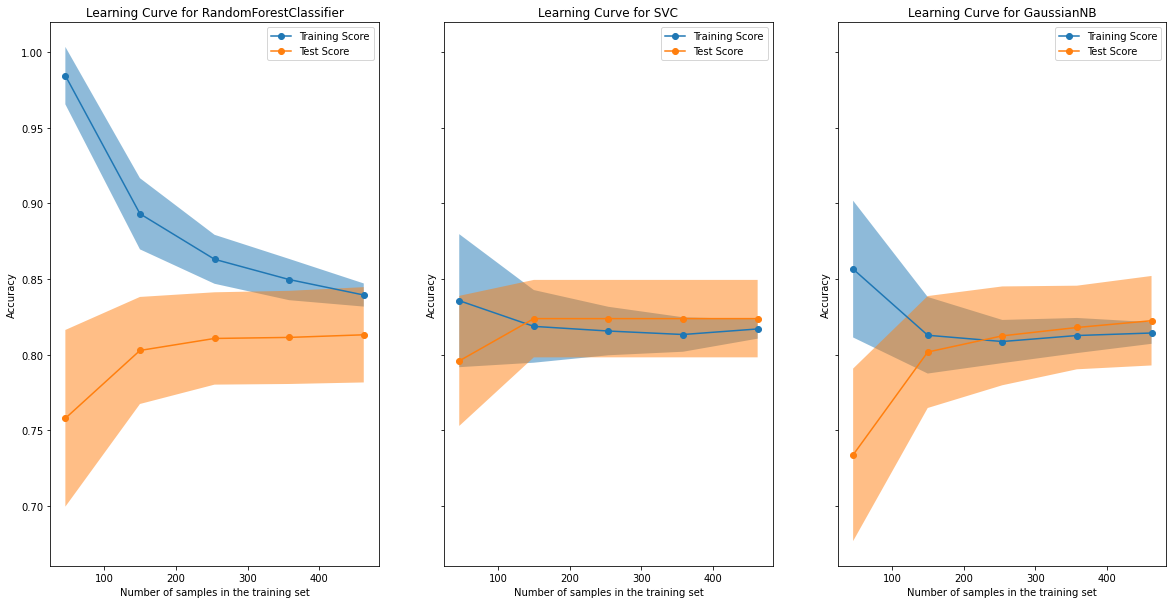

In [24]:
#%%time
# 1. Import needed libraries
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit

# 2. Define Figure (1 row, 3 columns because we have 3 models for which we want to see the learning curves)
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 10), sharey=True)

# 3. Define parameters that are common to all 3 models in our comparison
common_params = {
    "X": X_scaled,
    "y": y,
    "train_sizes": np.linspace(0.1, 1.0, 5), # gradual increase of samples in training set
    "cv": ShuffleSplit(n_splits=25, test_size=0.2), # define number of splits into training and test during CV as well as test set size: Increasing splits increases runtime!
    "score_type": "both", 
    "n_jobs": -1,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy", # Just a label! You cannot change the scoring function here
}

# 4. Run a Loop where for each Estimator a learnign curve is created and plottet
for ax_idx, estimator in enumerate([best_forest, best_svm, best_NB]):
    LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax[ax_idx])
    handles, label = ax[ax_idx].get_legend_handles_labels()
    ax[ax_idx].legend(handles[:2], ["Training Score", "Test Score"])
    ax[ax_idx].set_title(f"Learning Curve for {estimator.__class__.__name__}")

> **What do you observe?** 

> **Ask yourself**: What is the consequence of my observation?

# 3. Dealing with Class Imbalance

> **Imbalanced Dataset:** The training samples are not equally distributed across the target classes. 

- Class imbalance can be a problem because our classifier may not learn enough about the underrepresented class
  * Classifier might be prone to always predict overrepresented class (e.g., Tar Heels vs. Blue Devils example from our previous class)
  * More Type II errors

- We can mitigate the problem by either:
  * Upsampling: Adding more samples of the underrepresented class
  * Downsampling: Removing samples from the overrepresented class

> What are the challenges and potential problems with each strategy?



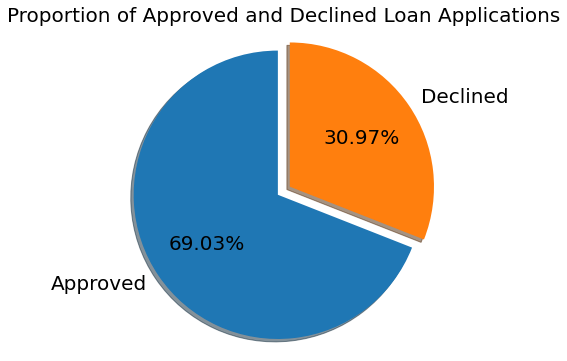

In [25]:
# 1. Let's check many loan request were approved vs declined in our preprocessed data
labels = 'Approved', 'Declined'
sizes = y[:].value_counts()[1], y[:].value_counts()[0]
explode = (0, 0.1)

fig1, ax1 = plt.subplots(figsize=(8, 6))
ax1.pie(sizes, explode=explode, labels=labels,  autopct='%1.2f%%', textprops={'fontsize': 20},
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Proportion of Approved and Declined Loan Applications", size = 20)
plt.rcParams['font.size'] = 18  # makes label size bigger

plt.show()

## 3.1 Upsampling Data

- Synthetically generated data points (corresponding to minority class) are injected into the dataset. 
- Counts of both labels are almost the same. 
- Prevents the model from inclining towards the majority class. 
- Introduces bias because of the additional information.

There are various approaches for upsampling, for example:

1. **Duplication**: 
    - Duplicate data points of the minority class
2. **SMOTE** (SyntheticMinorityOversamplingTechnique):
    - Based on the KNearestNeighbours algorithm
    - Synthetically generating data points that fall in the proximity of existing data points of the minory class. 
    - Beware: The input data points should not have any missing values 

#### **IMPORTANT**: Upsample only AFTER you split Data into Training and Testing sets
- Avoids Leakage: same (or similar) sample in both train and test

> *Make sure to also test your final model on the original training and testing sets to get a better impression on how well it performs*

### 3.1.1 Split Data into Train and Test

In [26]:
# 1 Split sample into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y, test_size=0.2, stratify=y, random_state=42)

# 2 Check if data have right shape
print("Train: Response Variable: ",y_train.shape)
print("Train: Feature Variables: ",X_train.shape)
print("Test: Response Variable: ",y_test.shape)
print("Test: Feature Variables: ",X_test.shape)

# 3 Check Class Balance
print(y_train.value_counts())

Train: Response Variable:  (462,)
Train: Feature Variables:  (462, 23)
Test: Response Variable:  (116,)
Test: Feature Variables:  (116, 23)
1    319
0    143
Name: Loan_Status, dtype: int64


### 3.1.2 Upsample Training Data

> *We will use Duplication to upsample our minority class*

In [27]:
# 1. Import libraries
from sklearn.utils import resample

# 2. Create a copy of our training data frame and add lables to it
up = X_train.copy()
up["y"]=y_train

# 3. Check Class Imbalance
print(up["y"].value_counts()) #fewer observations in category 0 (No Loan), so try to upsample category 0 to make a more balanced dataset

# 4. Split the observations by class
Loan = up[up["y"] == 1] #split the classes
No_Loan = up[up["y"] == 0]#split the classes

# 5. Sample (with replacement) minority class observations
No_Loan_upsample = resample(No_Loan,replace=True,n_samples=len(Loan),random_state=23) #upsampling to create balanced dataset

# 6. Concatenate dataframes again to make upsampled training data
up = pd.concat([Loan, No_Loan_upsample])

# 7. Purge temporary dataframes
Loan=[]
No_Loan=[]

# 8. Create upsampled X and y dataframes
X_up=up.drop(columns = "y").copy()
y_up=up['y']

# 9. Check if data have right shape and that classes are balanced
print("y_up: Response Variable: ",y_up.shape)
print("X_up: Feature Variables: ",X_up.shape)
print(y_up.value_counts())

1    319
0    143
Name: y, dtype: int64
y_up: Response Variable:  (638,)
X_up: Feature Variables:  (638, 23)
0    319
1    319
Name: y, dtype: int64


### 3.2 Re-Fit on Upsampled Data
- We will use a random forest
- We will check out prediction for the test and original train data

> Random Forest Trained on Imbalanced Data

In [28]:
# 1 Import Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

# 2 Instantiate Model (i.e., define it)
rforiginal = RandomForestClassifier(n_estimators = 50, max_depth = 5, max_features = 7, random_state=23)

# 3 Fit Model on Imbalanced Training Data
rforiginal.fit(X_train, y_train)

# 4 Make Prediction on test data
y_pred = rforiginal.predict(X_test)

# 5 Evaluate Performance
from sklearn.metrics import accuracy_score, precision_score, recall_score
print(f"Train: Accuracy {round(accuracy_score(y_train, rforiginal.predict(X_train))*100,2)}%  Precision {round(precision_score(y_train, rforiginal.predict(X_train))*100,2)}%  Recall {round(recall_score(y_train, rforiginal.predict(X_train))*100,2)}%")
print(f"Test:  Accuracy {round(accuracy_score(y_test, y_pred)*100,2)}%  Precision {round(precision_score(y_test, y_pred)*100,2)}%  Recall {round(recall_score(y_test, y_pred)*100,2)}%")

Train: Accuracy 83.77%  Precision 81.44%  Recall 99.06%
Test:  Accuracy 82.76%  Precision 80.61%  Recall 98.75%


> Random Forest Trained on Upsampled Data

In [29]:
# 1 Let's tune the Hyperparameters of a Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

# 2 Instantiate Model (i.e., define it)
rfup = RandomForestClassifier(n_estimators = 50, max_depth = 5, max_features = 7, random_state=23)

# 3 Fit Model on Upsampled Training Data
rfup.fit(X_up, y_up)

# 4 Make Prediction on test data
y_pred = rfup.predict(X_test)

# 5 Evaluate Model
from sklearn.metrics import accuracy_score, precision_score, recall_score
print(f"Train: Accuracy {round(accuracy_score(y_up, rfup.predict(X_up))*100,2)}%  Precision {round(precision_score(y_up, rfup.predict(X_up))*100,2)}%  Recall {round(recall_score(y_up, rfup.predict(X_up))*100,2)}%")
print(f"Test:  Accuracy {round(accuracy_score(y_test, y_pred)*100,2)}%  Precision {round(precision_score(y_test, y_pred)*100,2)}%  Recall {round(recall_score(y_test, y_pred)*100,2)}%")

Train: Accuracy 79.94%  Precision 71.66%  Recall 99.06%
Test:  Accuracy 84.48%  Precision 82.29%  Recall 98.75%


> Let's look at the Confusion Matrix

              precision    recall  f1-score   support

           0       0.95      0.53      0.68        36
           1       0.82      0.99      0.90        80

    accuracy                           0.84       116
   macro avg       0.89      0.76      0.79       116
weighted avg       0.86      0.84      0.83       116



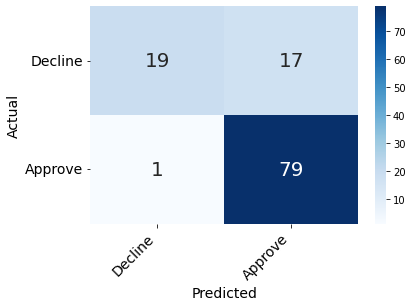

In [30]:
# 2 Print the classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

# 3 Visualize the confusion matrix to make it easier to read
from sklearn.metrics import confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

# 3a Create a function that visualizes the confusion matrix
def viz_conf_mat(y_test, y_pred):
  con_matrix = confusion_matrix(y_test, y_pred)
  confusion_matrix_df = pd.DataFrame(con_matrix, ('Decline', 'Approve'), ('Decline', 'Approve'))
  heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 20}, fmt="d", cmap="Blues")
  heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
  heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize = 14)
  plt.ylabel('Actual', fontsize = 14)
  plt.xlabel('Predicted', fontsize = 14)

# 3b Call function to visaulize the confusiton matrix
viz_conf_mat(y_test, y_pred)

**Precision** is intuitively the ability of the classifier not to label as positive a sample that is negative

**Recall** is intuitively the ability of the classifier to find all the positive samples.

**The F1 score** is the harmonic mean of the precision and recall

**Support** is the number of occurrences of each class in the "ground truth" (i.e., correct) target values.

**Averages** include:
- macro average (averaging the unweighted mean per label)
- weighted average (averaging the support-weighted mean per label)
- sample average (only for multilabel classification)

<p style="text-align: left; font-size:120%; font-weight: normal; font-style: normal;">
$Accuracy = \frac{t_p + t_n}{t_p + t_n + f_p + f_n}$ <br><br> 
$Precision = \frac{t_p}{t_p + f_p}$    <br><br>    
$Recall = \frac{t_p}{t_p + f_n}$   <br><br>    
$F1 score = 2 \times \frac{precision \times recall}{precision + recall}$ 
</p>

> **Where from here?**
- Hyperparametertuning?
- Cross-Valdiation?

# 4. Feature Importance in Tree Models

### Advantage of Tree-based methods: 
- Enable measuring the importance of each feature in prediction.
- WARNING: Does not reveal causality! This is not a model for statistical inference.

### In sklearn:
- How much the tree nodes use a particular feature (weighted average) to reduce impurity
  accessed using the attribute feature_importance_

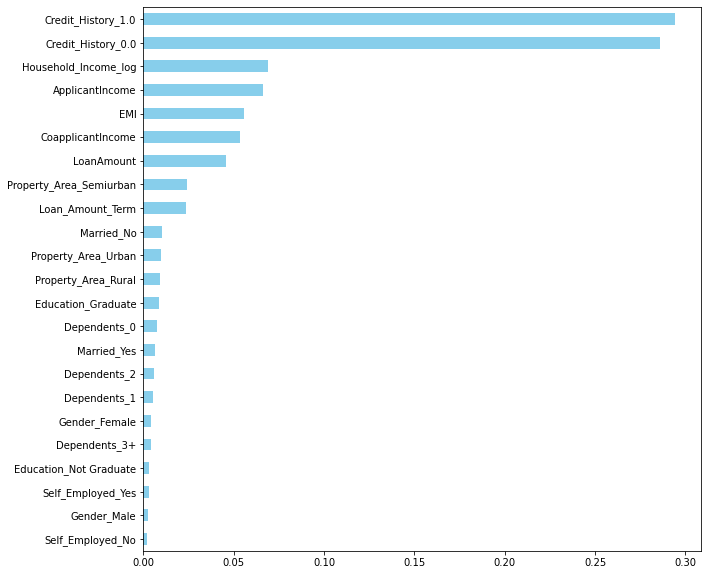

In [31]:
# 1. Create a pd.Series of features importances
importances_rf = pd.Series(rfup.feature_importances_, index = X.columns)

# 2. Sort importances_rf
sorted_importances_rf = importances_rf.sort_values()

# 3. Make a horizontal bar plot
plt.figure(figsize=(10,10))
sorted_importances_rf.plot(kind='barh', color='skyblue'); 
plt.show()

## 4.1. Challenges with Feature Importance

We just used ***model.feature_importances_*** to determine how important each feature is for our trained (random forest) model.
* No statistical inference!
* How much a feature is used in each tree of the forest. 
  * Formally, computed as (normalized) total reduction of impurity because of a feature.
* **Problem:** 
  * Impurity-based feature importance can ***inflate importance*** of numerical features.
  * Computed on ***statistics derived from training dataset***
    *  Importances can be high even for features that are not predictive of the target variable ...
    * ... as long as model has capacity to use them to overfit.



## 4.2 Permutation Feature Importance

**Permutation feature importance** is a ***model inspection technique*** that can be ***used for any*** fitted estimator when the data is tabular. 
* Especially useful for non-linear or opaque estimators. 
* Defined as ***decrease in a model's score*** when a ***single feature value*** is ***randomly shuffled***
 * Procedure breaks relationship between feature and target
 * Drop in model score indicative of how much model depends on feature
* Is ***model agnostic***
* Can be calculated many times with different permutations 
* Mitigate limitations of ***model.feature_importances_***

-----

**Warning**   
* Features deemed of low importance for a bad model (low cross-validation score lecture 16) could be very important for a good model. 

* Always important to evaluate the predictive power of a model using a held-out set (lecture 16) prior to computing importances
* Permutation importance ***does not reflect to the intrinsic predictive value of a feature by itself*** ...
* ... but ***how important feature*** is ***for a particular model***.

-----

*Learn more at: [SciKitLearn Permutation feature importance](https://scikit-learn.org/stable/modules/permutation_importance.html)*
and [Permutation Importance vs Random Forest Feature Importance](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html)


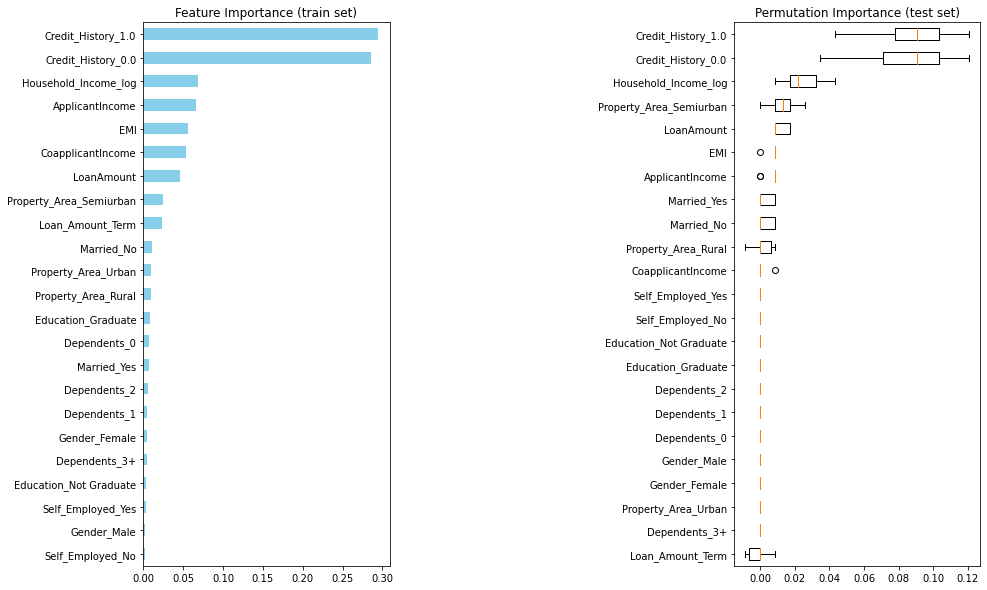

In [32]:
# 1. Import some libraries
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

# 2. Create a pd.Series of features importances
importances = pd.Series(rfup.feature_importances_, index = X.columns)
permImp = permutation_importance(rfup, X_test, y_test, 
                                 n_repeats=10, random_state=42, n_jobs=-1)

# 3. Sort importances
sorted_importances = importances.sort_values()
sorted_idx = permImp.importances_mean.argsort()

# 4. Make a horizontal bar plot
plt.figure(figsize=(15,10))
plt.subplot(1, 3, 1)
sorted_importances.plot(kind='barh', color='skyblue');
plt.title("Feature Importance (train set)") 

plt.subplot(1, 3, 3)
plt.boxplot(
    permImp.importances[sorted_idx].T,
    vert=False,
    labels=np.array(X.columns)[sorted_idx],
)
plt.title("Permutation Importance (test set)")
plt.show()


# **Looking Ahead:**  


![Spring Break](https://www.athlosutah.org/wp-content/uploads/2018/09/Spring_Break.png)


###**Next Class:** Tuesday, March 21, 2023  

#### ***Customer Churn*** *- Who to keep and who to let go?*
 - **IMPORTANT**: Download Class 18 Notebook and data from Canvas ***before*** class and ***run*** entire notebook on CoLab. 
 - **TAKE A CLOSE LOOK** at what the notebook does and what insights it produces. 
 - **BE PREPARED** to discuss the notebook in class!

